# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/mvv/anaconda3/envs/dlnd/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [273]:
rides.tail()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,...,0,0,0,0,1,0,0,0,0,0
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,...,0,0,0,0,1,0,0,0,0,0
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,...,1,0,0,0,1,0,0,0,0,0
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,...,0,1,0,0,1,0,0,0,0,0
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,...,0,0,1,0,1,0,0,0,0,0


In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

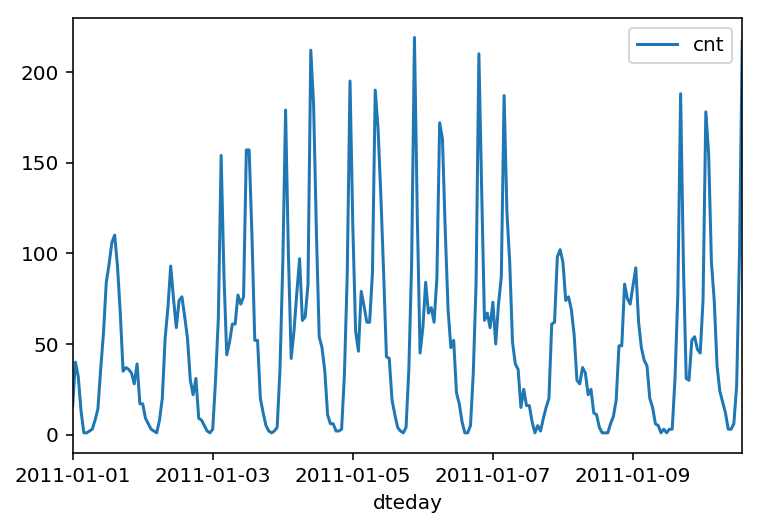

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [246]:
len(rides)

17379

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [128]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

    @classmethod
    def sigmoid(cls, x):
        return 1. / (1 + np.exp(-1 * x))

    def activation_function(self, x):
        return NeuralNetwork.sigmoid(x)
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_output = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_output, self.weights_hidden_to_output)
            # activation for hidden nodes is = f(x) = x
            final_output = final_inputs
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_output
            # activation function f(x) = x; => f'(x) = 1
            output_error_term = 1 * error

            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            hidden_error_term = hidden_error * hidden_output * (1 - hidden_output)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]

            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_output[:, None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
        final_outputs = final_inputs
        
        return final_outputs

In [129]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [130]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rateIf the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [278]:
#import sys

### Set the hyperparameters here ###
#iterations = 5000
#learning_rate = .8
#hidden_nodes = 15
#output_nodes = 1

# note: commented out hyperparameters represent a subset
# of my own manual testing

# iterations = 10000
# learning_rate = .4
# hidden_nodes = 8
# output_nodes = 1
# Training loss: 0.056 ... Validation loss: 0.147

# iterations = 10000
# learning_rate = .4
# hidden_nodes = 16
# output_nodes = 1
# Training loss: 0.056 ... Validation loss: 0.143

# iterations = 5000
# learning_rate = .4
# hidden_nodes = 16
# output_nodes = 1
# Training loss: 0.088 ... Validation loss: 0.160

# iterations = 20000
# learning_rate = .4
#hidden_nodes = 16
# output_nodes = 1
# Training loss: 0.052 ... Validation loss: 0.134
# unnaturraly long, overfit (validation hardly budges)

# iterations = 10000
# learning_rate = .4
# hidden_nodes = 32
# output_nodes = 1
# Training loss: 0.053 ... Validation loss: 0.138
# again, good results but not time efficient and validation hardly budges (overfit)

# iterations = 5000
# learning_rate = .8
# hidden_nodes = 15
# output_nodes = 1
#Training loss: 0.053 ... Validation loss: 0.140
# great results, time efficient
# learning rate is so high!

# iterations = 5000
# learning_rate = .01
# hidden_nodes = 15
# output_nodes = 1
# Training loss: 0.433 ... Validation loss: 0.704

# iterations = 5000
# learning_rate = .1
# hidden_nodes = 15
# output_nodes = 1
# Training loss: 0.248 ... Validation loss: 0.416

# iterations = 5000
# learning_rate = .2
# hidden_nodes = 15
# output_nodes = 1
# Training loss: 0.209 ... Validation loss: 0.367

# iterations = 5000
# learning_rate = .9
# hidden_nodes = 15
# output_nodes = 1
# Training loss: 0.064 ... Validation loss: 0.136

iterations = 5000
learning_rate = .4
hidden_nodes = 15
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.079 ... Validation loss: 0.166

### Manual Testing Summary

**Note**: This summary is from my initial manual testing and very anecdotal.  Please check out `first_neural_network_hyperparameters.ipynb` for a more thorough analysis.

Looking at the results sorted by least combined training and validation error it was clear that networks trained with a learning rate of `0.9` were the most effective, but a learning rate as low as `0.4` achieved satisfactory results.  Learning rates lower than `0.4` consistently did not converge across the variety of hyperparameters I tried.  I saw some anecdotal evidence on the forum and Slack that suggested reviewers may be looking for learning rates as low as `0.01`.  I was not able to reproduce successful results even with ridiculously large iteration and network sizes with learning rates this low (perhaps something is incorrect about the design of my network?).

16 hidden nodes seemed to be the sweet spot, but network sizes as low as 8 were also effective.  Higher number of iterations consistently would produce better results but achieved diminishing returns after ~5000 iterations and the amount of time these training sessions would take seemed to against the spirit of the rubric (the training session needed to be time efficient).

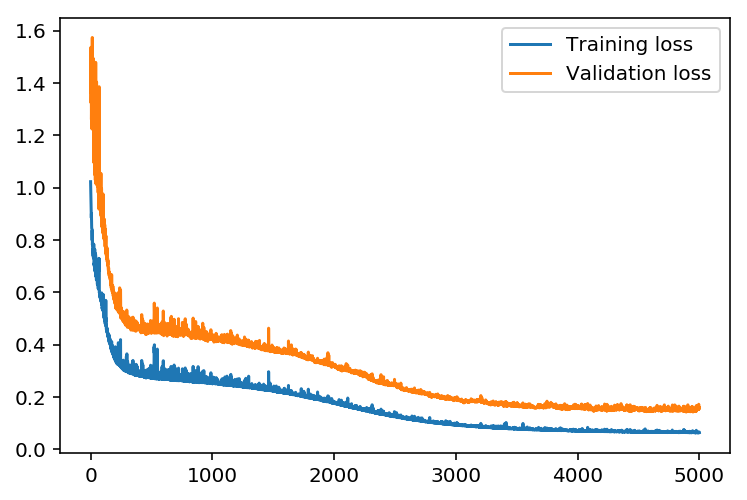

In [275]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

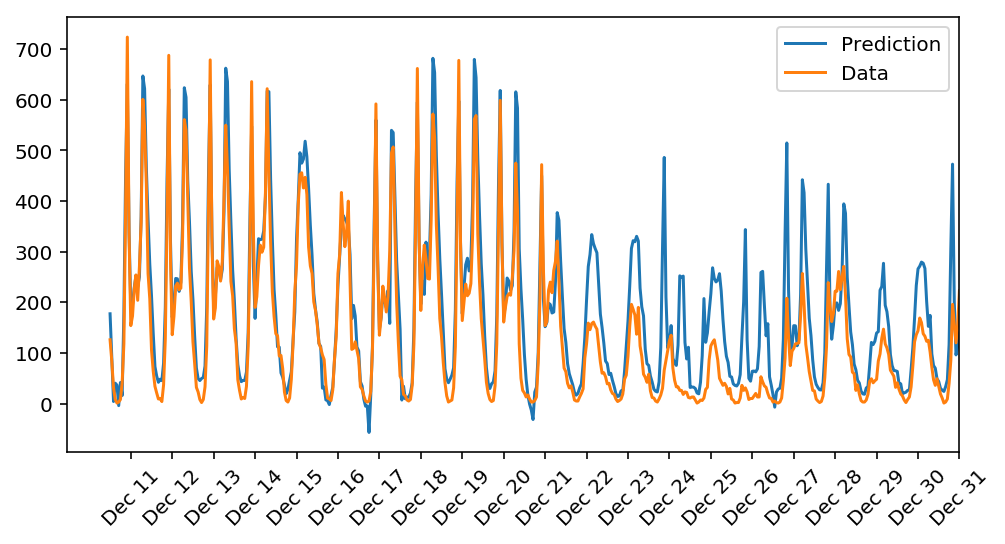

In [272]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## hyperparameter fishing

** <span style='color:red'> Note: I have a lot more involved analysis on hyperparameters in `first_neural_network_hyperparameters.ipynb`.  Please refer to that notebook for further findings.**

The "good enough" hyperparameters I found for my network manually, decided to use on
this assignment and have configured above were:

```
iterations = 5000
learning_rate = .4
hidden_nodes = 15
```

This "good enough" network achieved a training loss of `0.064` and a validation loss: `0.136`. 

## absolute best

These hyperparameters did not yield the _absolute best_ results I achieved, but the parameters seem to fit the spirit of the rubic better than the actual best hyperparameters I found which were not time efficient and were very nearly as effective as the actual best performing parameters.  There were two candidates I considered for "absolute best" (keep in mind that there's a level of stochasticity in the loss results calculated)

**combined loss best**

```
hidden_nodes = 16
learning_rate = 0.9
iterations = 160000
```


The combined loss best achieved `0.04848107395328171` training loss and `0.1258723144999932` validation loss 

**validation loss best**

```
hidden_nodes = 16
learning_rate = 0.8
iterations = 16000
```

This validation loss best network achieved `0.0550502588863` training loss and  `0.11960366476` validation loss.


### Manual Hyperparameter Fishing Notes

After fiddling around with parameters for a while I got a little frustrated at my results.  My findings were running counter to my intuitions.  I was finding that a learning rate *substantially higher* than what I was thinking based on the assignment notes was more effective and brought down both the training _and_ validation error significantly compared to learning rates closer to the initial suggested value of `0.1`.

The copy in the notebook assignment above suggested that "if the network has problems fitting the data, try reducing the learning rate." What I found for this network ran counter to this suggestion.  Lower learning rates below or around `0.1` had really bad training and validation losses upwards 40%.  My neural nets weren't much better than coin flips.  This seemed to be true regardless of the number of output nodes or iterations I picked.

In addition to this oddity, no matter what I did I couldn't achieve a validation error much lower than `0.13` and a training error lower than `0.04` to `0.06`.  I was significantly concerned about overfitting since we were getting such a high validation loss at roughly 2-3x what the training set could achieve.  After looking around on the forums however I concluded that I was likely achieving the upper bound of performance out of the assignment network.  This hypothesis seemed echoed by the response from the class mentor who responded to my inquiry about my network performance on the forum.

To get a more definitive answer on choice of hyperparameter I decided to search the parameter space across a number of different iteration, hidden node and learning rate parameters and see which ones were the most effective.

## Automated hyperparameter searching

The block below runs the training procedure and calculates 
training and validation loss across a number of different
possible iterations, hidden_nodes, output-nodes, and learning 
rates.

In [271]:
import pickle

g_iterations = [500, 1000, 2000, 4000, 8000, 16000] 
g_hidden_nodes = [2, 4, 6, 8, 16, 32]
g_output_nodes = 1
g_learning_rates = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 0.9]

results = []

def train_and_get_efficacy(hidden_nodes, output_nodes, learning_rate, iterations):
    print(hidden_nodes, output_nodes, learning_rate, iterations)
    
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[]}
    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
        network.train(X, y)
    
        # Printing out the training progress
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
        sys.stdout.flush()
    
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        results.append((
            hidden_nodes,
            output_nodes,
            learning_rate,
            iterations,
            train_loss,
            val_loss
        ))
        
for learning_rate in g_learning_rates:
    for hidden_node in g_hidden_nodes:
        for iteration in g_iterations:
            train_and_get_efficacy(hidden_node, output_nodes, learning_rate, iteration)


2 1 0.01 500
Progress: 99.8% ... Training loss: 0.864 ... Validation loss: 1.3012 1 0.01 1000
Progress: 99.9% ... Training loss: 0.956 ... Validation loss: 1.3682 1 0.01 2000
Progress: 100.0% ... Training loss: 0.783 ... Validation loss: 1.2632 1 0.01 4000
Progress: 100.0% ... Training loss: 0.532 ... Validation loss: 0.8792 1 0.01 8000
Progress: 100.0% ... Training loss: 0.339 ... Validation loss: 0.5512 1 0.01 16000
Progress: 100.0% ... Training loss: 0.273 ... Validation loss: 0.4414 1 0.01 500
Progress: 99.8% ... Training loss: 0.812 ... Validation loss: 1.2614 1 0.01 1000
Progress: 99.9% ... Training loss: 0.743 ... Validation loss: 1.2714 1 0.01 2000
Progress: 100.0% ... Training loss: 0.643 ... Validation loss: 1.1124 1 0.01 4000
Progress: 100.0% ... Training loss: 0.477 ... Validation loss: 0.7824 1 0.01 8000
Progress: 100.0% ... Training loss: 0.337 ... Validation loss: 0.5534 1 0.01 16000
Progress: 100.0% ... Training loss: 0.270 ... Validation loss: 0.4366 1 0.01 500
Progres

KeyboardInterrupt: 

Run this next block if you want to re-serialize the results in 
both pickle and csv formats after running the block above

In [ ]:
import csv

with open('results.pik', 'wb') as file_obj:
    file_obj.write(pickle.dumps(results))

with open('results.csv', 'w') as file_obj:
    writer = csv.writer(file_obj, delimiter=',', quotechar='"')
    for line in results:
        writer.writerow(list(line))

In [ ]:
sorted_results = sorted([(r, sum(r[-2:])) for r in results], key=lambda x: x[1])

from pprint import pprint
pprint(sorted_results[:200])

In [277]:
sorted_results[0]

((16, 1, 0.9, 16000, 0.04848107395328171, 0.1258723144999932),
 0.17435338845327492)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

Predictions areound December 22 - 31 are particularly terrible.  Other than that it seems like the 
network does a fairly good job of predicting the spikes and falls of a given day.

There are a few days where we'd have too little capacity but in general,particularly during this
peak holiday season, we have way more capacity than we can handle.  On the one hand this is good
for our quality of service (we will have a bike for people in general, although there's a few 
days we miss).  On the other hand this improved quality would cost the business as there'd be
unused surplus that we'd have to requisition.  The holiday season we fail to predict doesn't have
as much demand as times we do predict well, so the good news is if bikes are in repair during this
part of the season we have likely already spent the bulk of the $ on the peak days beforehand, 
so failing to predict the holidays probably isn't totally breaking the bank.

It's possible that the Dec 22 - 31 part of the season is sufficiently different from the rest of
the data that it is an outlier our neural net is unable to predict.  We seem to think we'll have
more demand than we do.  I think this is because on days when we have demand we tend to have a lot
higher demand than on days during this holiday season.  It's also possible that we've overfit to
days that aren't this holiday season.  More sampling around this period (possibly across years?)
could probably help us predict bike demand on these days.  Adding a `holiday` term might also 
help.

We also never seem to predict 0 bikes but experience days without bikes (likely because the shop 
is closed).  I suspect adding the `workday` and `weekday` input dummy variables could likely get 
us better predictions days with 0 bike demand.